# Sentiment Analysis
Use the newsapi to pull the latest news articles for Amazon and create a DataFrame of sentiment scores.

In [1]:
# Initial imports
import os
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
from newsapi import NewsApiClient
import nltk as nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/soma/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Read the api key environment variable**

In [2]:
load_dotenv()

True

**Load the Amazon closing prices data**

In [3]:
file_path = Path('Resources/amzn_closing_prices.csv')
amzn_df = pd.read_csv(file_path, infer_datetime_format=True, parse_dates=True)
amzn_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-01-03,181.369995,186.000000,181.210007,184.220001,184.220001,5331400
1,2011-01-04,186.149994,187.699997,183.779999,185.009995,185.009995,5031800
2,2011-01-05,184.100006,187.449997,184.070007,187.419998,187.419998,3418800
3,2011-01-06,186.500000,187.410004,185.250000,185.860001,185.860001,3179700
4,2011-01-07,187.880005,188.449997,183.740005,185.490005,185.490005,5221700


In [4]:
amzn_df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

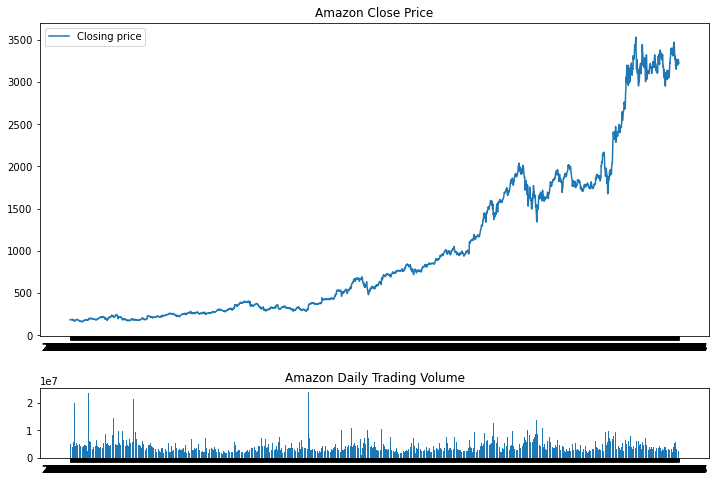

In [5]:
top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(amzn_df['Date'], amzn_df['Close'], label = 'Closing price')
plt.title('Amazon Close Price')
plt.legend(loc=2)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(amzn_df["Date"], amzn_df["Volume"])
plt.title('Amazon Daily Trading Volume')
plt.gcf().set_size_inches(12,8)
plt.subplots_adjust(hspace=0.75)

In [6]:
amzn_df['Date'] = pd.to_datetime(amzn_df['Date']).dt.date

In [7]:
amzn_df = amzn_df.set_index('Date')

**Create a newsapi client**

To get access of all the latest articles about Amazon company, we need to call NewsApiClient by passing NEWS_API_KEY.

In [8]:
newsapi = NewsApiClient(api_key=os.getenv("NEWS_API_KEY"))

**Fetch the Amazon news articles from newsapi.org by using get_everything function**

get_everything returns articles from large and small news sources and blogs.

In [10]:
amzn_news_articles = newsapi.get_everything(
    q="Amazon AND AMZN",
    language="en",
    page_size=100,
    sort_by="relevancy"
)

**Define sentiment dataframe function which is used to create Amazon sentiment scores**

In [11]:
def get_sentiments_df(articles):
    # Create the sentiment scores DataFrame
    sentiments = []
    for article in articles["articles"]:
        try:
            text = article["description"]
            date = article["publishedAt"][:20]
            sentiment = analyzer.polarity_scores(text)
            compound = sentiment["compound"]
            pos = sentiment["pos"]
            neu = sentiment["neu"]
            neg = sentiment["neg"]

            sentiments.append({
                "Text": text,
                "Date": date,
                "Compound": compound,
                "Positive": pos,
                "Negative": neg,
                "Neutral": neu

            })

        except AttributeError:
            pass
        
    # Create DataFrame
    df = pd.DataFrame(sentiments)
    
    # Reorder DataFrame columns
    cols = ["Date", "Text", "Compound", "Positive", "Negative", "Neutral"]
    df = df[cols]
    
    return df

**Create Amazon sentiment scores DataFrame**

Here we use get_sentiments_df function by passing amzn_news_articles argument for amazon news article.

In [12]:
amzn_sentiment_df = get_sentiments_df(amzn_news_articles)
amzn_sentiment_df.head()

,Date,Text,Compound,Positive,Negative,Neutral
0,2021-06-01T23:54:45Z,Amazon announced Tuesday it supports the feder...,0.0516,0.119,0.114,0.767
1,2021-05-08T00:19:18Z,Summary List PlacementAn Amazon worker died Th...,-0.8313,0.039,0.220,0.741
2,2021-05-27T14:25:36Z,The e-commerce industry is continuing to gener...,0.1779,0.042,0.000,0.958
3,2021-05-20T02:03:36Z,Summary List PlacementAmazon is facing a wave ...,-0.7003,0.000,0.155,0.845
4,2021-05-06T15:58:06Z,Summary List PlacementAmazon work rules regula...,0.0000,0.000,0.000,1.000


**Describe the Bitcoin and Ethereum Sentiment**

The describe function gives a summary of statistics of amzn_sentiment_df dataframe.

In [13]:
amzn_sentiment_df.describe()

,Compound,Positive,Negative,Neutral
count,100.000000,100.000000,100.000000,100.000000
mean,0.236375,0.126130,0.037050,0.836830
std,0.377654,0.115364,0.065115,0.133395
min,-0.831300,0.000000,0.000000,0.497000
25%,0.000000,0.000000,0.000000,0.737500
50%,0.177900,0.116500,0.000000,0.845500
75%,0.535325,0.183500,0.070000,0.973750
max,0.913600,0.492000,0.237000,1.000000


In [14]:
amzn_scores_df = pd.DataFrame(amzn_sentiment_df[['Date', 'Compound', 'Positive', 'Negative', 'Neutral']])
# Convert the date column from string to datetime
amzn_scores_df['Date'] = pd.to_datetime(amzn_scores_df['Date']).dt.date
amzn_scores_df = amzn_scores_df.groupby(['Date']).mean()
amzn_scores_df.head()

,Compound,Positive,Negative,Neutral
Date,,,,
2021-05-03,0.339667,0.176667,0.000000,0.823333
2021-05-04,0.278357,0.084143,0.005286,0.910571
2021-05-06,0.173829,0.111143,0.044714,0.844143
2021-05-07,0.305750,0.061000,0.000000,0.939000
2021-05-08,-0.831300,0.039000,0.220000,0.741000


**Let us join `amzn_scores_df` and `amzn_df` dataframes**

In [15]:
# join it with main dataframe
df = pd.merge(amzn_df, amzn_scores_df, on='Date', how='inner')
df.head()

,Open,High,Low,Close,Adj Close,Volume,Compound,Positive,Negative,Neutral
Date,,,,,,,,,,
2021-05-03,3484.729980,3486.649902,3372.699951,3386.489990,3386.489990,5875500,0.339667,0.176667,0.000000,0.823333
2021-05-04,3356.189941,3367.979980,3272.129883,3311.870117,3311.870117,5439400,0.278357,0.084143,0.005286,0.910571
2021-05-06,3270.000000,3314.399902,3247.199951,3306.370117,3306.370117,4447700,0.173829,0.111143,0.044714,0.844143
2021-05-07,3319.090088,3330.889893,3289.070068,3291.610107,3291.610107,4706800,0.305750,0.061000,0.000000,0.939000
2021-05-10,3282.320068,3283.000000,3190.000000,3190.489990,3190.489990,5838600,0.237000,0.104500,0.056000,0.839500


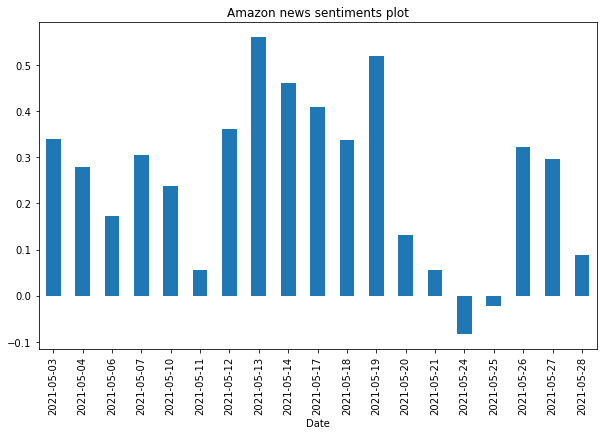

In [16]:
# Plot a bar chart with pandas
sentiment_plot = df['Compound'].plot.bar(x='Date', y='Compound', figsize=(10,6), title='Amazon news sentiments plot')

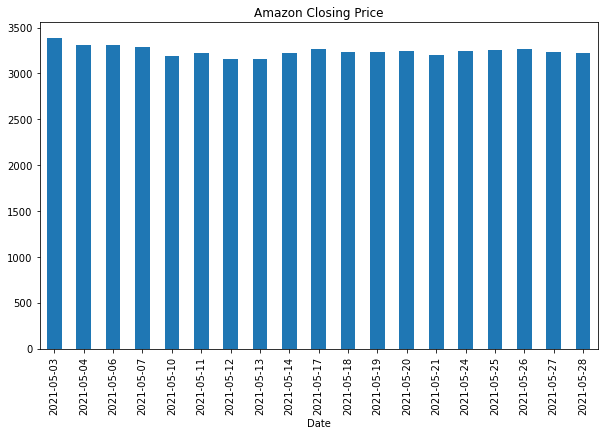

In [17]:
# Plotting stock 
amzn_stock_plot = df['Close'].plot.bar(x='Date', y='Close', figsize=(10,6), title='Amazon Closing Price')

## Natural Language Processing
Tokenizer
In this section, we will use NLTK and Python to tokenize the text for each coin. We will perform the following tasks to preprocess the text:

Tokenization: Tokenization is a process of creating tokens by splitting the larger text into smaller sentences, words or phrases.
Lemmatization: It is a technique to standardize the words by ensuring that the root word that is also called lemma(dictionary form of word) belongs to the language.
Lowercase each word.
Remove Punctuation.
Remove Stopwords Stopwords are the words which does not add much meaning to the sentence, if we remove the stopwords the meaning of the sentence does not change.

In [18]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

**Instantiate the lemmatizer**

In [19]:
lemmatizer = WordNetLemmatizer()

**Create a list of stopwords**

In [20]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

**Expand the default stopwords list**

In [21]:
exp_stop_words = [
    'This', 
    'said', 
    'ha', 
    'dont', 
    'youve', 
    'even', 
    'images',
    'getty',
    'com',
    'watch',
    'via', 
    'char'
    'li',
    'ol',
    'inc',
    'originally',
    'illustration',
    'according',
    'general',
    'summary',
    'list',
    'placementan',
    'placementamazon',
    'still'
    
]

**Define the tokenizer function to create a new tokens column for Amazon dataframe**

Tokenization is a process of creating tokens by splitting the larger text into smaller sentences, words or phrases.

In [22]:
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the punctuation from text
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub(' ', text)
    
    # Create a tokenized list of the words
    words = word_tokenize(re_clean)
    
    # Lemmatize words into root words
    lem = [lemmatizer.lemmatize(word) for word in words]
    
    # Remove the stop words
    sw = set(stopwords.words('english') + exp_stop_words)
    not_sw = [word for word in lem if word.lower() not in sw]
    
    # Convert the words to lowercase
    tokens = [word.lower() for word in not_sw]
    
    return tokens

**Create a new tokens column for Amazon**

In [23]:
amzn_tokens = []

for text in amzn_sentiment_df['Text']:
    amzn_tokens.append(tokenizer(text))
    
amzn_sentiment_df['Tokens'] = amzn_tokens
amzn_sentiment_df.head()

,Date,Text,Compound,Positive,Negative,Neutral,Tokens
0,2021-06-01T23:54:45Z,Amazon announced Tuesday it supports the feder...,0.0516,0.119,0.114,0.767,"[amazon, announced, tuesday, support, federal,..."
1,2021-05-08T00:19:18Z,Summary List PlacementAn Amazon worker died Th...,-0.8313,0.039,0.220,0.741,"[amazon, worker, died, thursday, collapsing, c..."
2,2021-05-27T14:25:36Z,The e-commerce industry is continuing to gener...,0.1779,0.042,0.000,0.958,"[e, commerce, industry, continuing, generate, ..."
3,2021-05-20T02:03:36Z,Summary List PlacementAmazon is facing a wave ...,-0.7003,0.000,0.155,0.845,"[facing, wave, five, new, lawsuit, filed, wedn..."
4,2021-05-06T15:58:06Z,Summary List PlacementAmazon work rules regula...,0.0000,0.000,0.000,1.000,"[work, rule, regulate, delivery, driver, perso..."


**NGrams and Frequency Analysis**

In this section we will look at the ngrams and word frequency.

Use NLTK to produce the n-grams for N = 2.
List the top 10 words for Amazon.
Lets import Counter and ngrams function

We use Counter as a tool to count the key-value pairs in an object, it holds the elements as dictionary keys and their count as dic values. and also use ngrams which is a sequence of n words where n is a number of words.

In [24]:
from collections import Counter
from nltk import ngrams

**Define top 10 ngrams counts function to generate the n-grams of Amazon**

Here we generate bigrams(combination of two words).

In [25]:
def ngrams_counts_top10(df, n):   
    amzn_bigrams = []
    for tokens in df.Tokens:
        bigrams = ngrams(tokens, n)
        amzn_bigrams.extend(bigrams)
    top_10 = dict(Counter(amzn_bigrams).most_common(10))
    return pd.DataFrame(list(top_10.items()), columns=['bigram', 'count'])

In [26]:
ngrams_counts_top10(amzn_sentiment_df, 2)

,bigram,count
0,"(e, commerce)",6
1,"(amazon, amzn)",6
2,"(stock, price)",5
3,"(amzn, stock)",4
4,"(amazon, nasdaq)",4
5,"(nasdaq, amzn)",4
6,"(tech, giant)",4
7,"(jeff, bezos)",3
8,"(whole, foods)",3
9,"(artificial, intelligence)",3


**Function token_count generates the top 10 words for a given Amazon**

In [27]:
def token_count(tokens, N=3):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

*Use token_count function to get the top 10 words for Amazon*

In [28]:
amzn_tokens = []
for tokens in amzn_sentiment_df.Tokens:
    amzn_tokens.extend(tokens) 
token_count(amzn_tokens, 10)

[('amazon', 55),
 ('stock', 38),
 ('company', 19),
 ('amzn', 17),
 ('business', 12),
 ('price', 12),
 ('tech', 10),
 ('year', 9),
 ('new', 8),
 ('growth', 8)]

### Word Clouds

In this section, we will generate word clouds for each coin to summarize the news for each coi

In [29]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

**Function generate_wordcloud generates the word cloud**

In [30]:
def generate_wordcloud(df):
    amzn_tokens = []
    for tokens in df.Tokens:
        amzn_tokens.extend(tokens)
    input_text = ' '.join(amzn_tokens)
    wc = WordCloud().generate(input_text)
    plt.imshow(wc)

*Use generate_wordcloud function to generate Amazon word cloud*

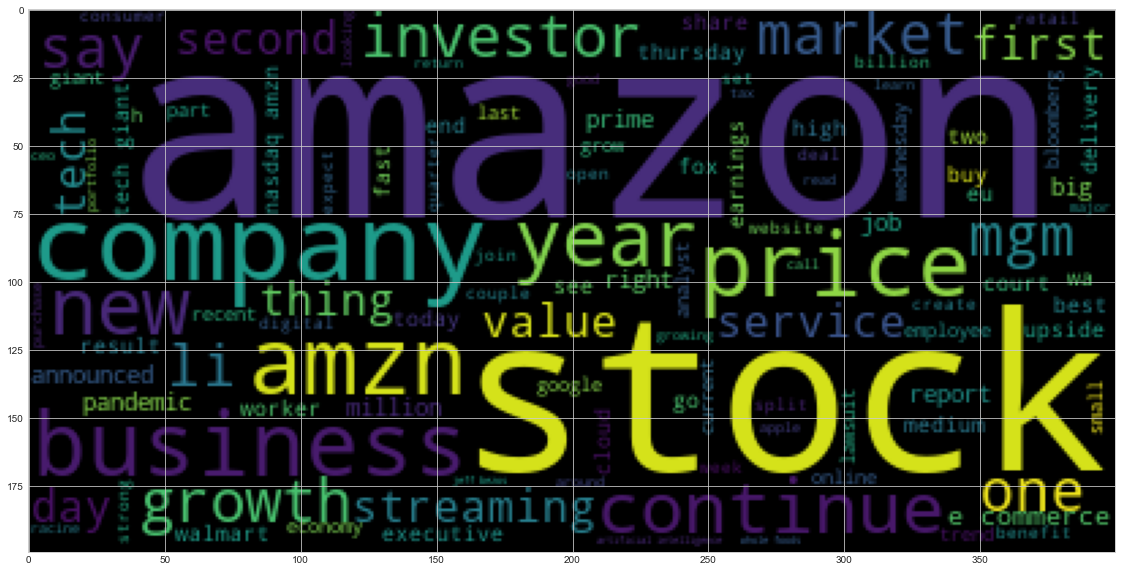

In [31]:
generate_wordcloud(amzn_sentiment_df)

## Named Entity Recognition
In this section, we will build a named entity recognition model for both Bitcoin and Ethereum, then visualize the tags using SpaCy.

In [32]:
import spacy
from spacy import displacy

**Download the language model for SpaCy**

In [33]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


**Load the spaCy model**

In [34]:
nlp = spacy.load('en_core_web_sm')

**Amazon NER**

Concatenate all of the Amazon text together

In [35]:
amzn_text = amzn_sentiment_df.Text.str.cat()

**Run the NER processor on all of the text**

In [36]:
amzn_doc = nlp(amzn_text)

**Add a title to the document**

In [37]:
amzn_doc.user_data["title"] = "Amazon NER"

**Render the visualization**

In [38]:
displacy.render(amzn_doc, style='ent')